In [40]:
import pandas as pd
import numpy as np

In [41]:
grades = pd.read_csv("grades.csv")
grades = grades.fillna(0)
grades.head()

,Student,ID,SIS User ID,SIS Login ID,Section,lab01 (914366),lab02 (916531),lab03 (918296),lab04 (919865),lab05 (922112),...,Discussions Final Score,Discussions Unposted Final Score,Homework Current Score,Homework Unposted Current Score,Homework Final Score,Homework Unposted Final Score,Current Score,Unposted Current Score,Final Score,Unposted Final Score
0,Points Possible,0.0,0,0,0,10.0,10.00,10.00,10.0,10.00,...,(read only),(read only),(read only),(read only),(read only),(read only),(read only),(read only),(read only),(read only)
1,"Abaghyan, Gor",221269.0,A18319402,gabaghyan,DSC 20 - A01 [741392],10.0,11.00,11.00,11.0,9.25,...,100.00,100.00,98.01,98.01,98.01,98.01,99.46,99.46,99.46,99.46
2,"Aggarwal, Pratham",220777.0,A18297392,praggarwal,DSC 20 - B01 [741530],11.0,11.00,11.00,10.5,10.25,...,100.00,100.00,98.90,98.90,98.90,98.90,102.08,102.08,102.08,102.08
3,"Agrawal, Aarav",197120.0,A17929245,a7agrawal,DSC 20 - B01 [741530],10.0,9.75,10.75,10.0,10.00,...,42.86,42.86,97.88,97.88,97.88,97.88,95.45,95.45,95.16,95.16
4,"Aguilera, Jesus",163219.0,A17532196,jeaguilera,DSC 20 - A01 [741392],11.0,11.00,11.00,11.0,10.00,...,71.43,71.43,93.12,93.12,93.12,93.12,84.76,84.76,84.03,84.03


In [42]:
# list of assignments, category weight, lowest scores dropped, and maximum score
rq, rq_weight, rq_drops, rq_cap = [], 0.05, 3, 1.0
lect, lect_weight, lect_drops, lect_cap = [], 0.02, 6, 1.0
disc, disc_weight, disc_drops, disc_cap = [], 0.02, 1, 1.0
lab, lab_weight, lab_drops, lab_cap = [], 0.07, 1, 1.0
hw, hw_weight, hw_drops, hw_cap = [], 0.14, 0, 1.0
proj, proj_weight, proj_drops, proj_cap = [], 0.1, 0, 1.0
st, st_weight, st_drops, st_cap = [], 0.15, 1, 1.0

# exams (grouped together when enforcing cap, hence the "dummy" cap)
mt, mt_weight, mt_drops, mt_cap = [], 0.15, 0, 2.0
final, final_weight, final_drops, final_cap = [], 0.3, 0, 2.0

exam_weight, exam_cap = 0.45, 1.0
slip_days_allowed = 5
max_pts = grades.iloc[0]
pid = ["SIS User ID"]

In [43]:
# place columns in respective categories
for col in grades.columns:
    c = col.lower()
    if c.endswith("score"):
        continue
    elif c.startswith("reading quiz"):
        rq.append(col)
    elif c.startswith("lecture"):
        lect.append(col)
    elif c.startswith("discussion"):
        disc.append(col)
    elif c.startswith("lab"):
        lab.append(col)
    elif c.startswith("hw"):
        hw.append(col)
    elif c.startswith("project"):
        proj.append(col)
    elif c.startswith("skill test"):
        st.append(col)
    elif c.startswith("midterm"):
        mt.append(col)
    elif c.startswith("final"):
        final.append(col)
    elif c.startswith("slip day usage"):
        slip_days = col
    else:
        # print assignments not belonging to any category
        print(col)

Student
ID
SIS User ID
SIS Login ID
Section
First Day Survey: Tell Me About Yourself #FinAid (909751)
Quiz 0 (Syllabus Quiz) (905578)
First Day Survey: Getting to Know You - #FinAid (909753)
First Day Survey: Prior Knowledge #FinAid (909748)


In [44]:
lect = [l for l in lect if not l.startswith("Lecture 00")]

# sanity check to count number of assignments in each category
cats = ["rq", "lect", "disc", "lab", "proj", "st", "final", "mt"]
for cat in cats:
    print(f"{cat}: {len(eval(cat))}", end = " | ")

rq: 22 | lect: 26 | disc: 8 | lab: 9 | proj: 1 | st: 6 | final: 0 | mt: 1 | 

In [45]:
# construct final dataframe
out = pd.DataFrame()
out["student"] = grades["Student"][1:-1]
out["pid"] = grades["SIS User ID"][1:-1]
out["sid"] = grades["SIS Login ID"][1:-1]
out.head()

,student,pid,sid
1,"Abaghyan, Gor",A18319402,gabaghyan
2,"Aggarwal, Pratham",A18297392,praggarwal
3,"Agrawal, Aarav",A17929245,a7agrawal
4,"Aguilera, Jesus",A17532196,jeaguilera
5,"Ahmed, Ali",A18523333,ala023


In [46]:
# create dataframe containing all slip day information
slip_day_df = out.copy(deep = True)
slip_day_cols = []

# combine all slip day files
for a in hw:
    a = a.split()[0]
    
    sd = pd.read_csv(f"slip_days/{a}_lateness.csv")[["SID", "Slip Day Used"]]
    slip_day_cols.append(f"{a}_slip_day")
    sd.columns = ["pid", f"{a}_slip_day"]

    slip_day_df = slip_day_df.merge(sd, on = "pid", how = "left")

slip_day_df[slip_day_cols] = slip_day_df[slip_day_cols].fillna(0).astype(bool)

# combine all hw assignments and normalize to proportions
subset = grades[pid + hw + [slip_days]].iloc[0:-1].copy().set_index(pid)
for a in hw:
    subset[a] = subset[a] / subset[a][0]

# combine slip days and assignment grades
combined = slip_day_df.merge(subset, left_on = "pid", right_index = True)

# check if students used more than the allowed slip days, and add a corresponding penalty
combined["penalty"] = (combined[slip_days] - slip_days_allowed).apply(lambda x: max(0, x)).astype(int)

# disclaimer: currently doesn't really suport drops
total = len(hw) - hw_drops

def calculate_hw_grade(df):
    if df["penalty"] > 0:
        # use slip day cols as a boolean mask over the hw scores, to get the scores of late assignments
        late_assignments = df[hw][df[slip_day_cols].values].astype(float)
        dropped = late_assignments.nsmallest(df["penalty"]).sum()
        
        return (df[hw].sum() - dropped) / total
    else:
        return df[hw].sum() / total
        
combined["hw_score"] = combined.apply(calculate_hw_grade, axis = 1)
combined["hw_score"] = np.clip(combined["hw_score"], 0, hw_cap)

# add score back to finalized dataframe
out = out.merge(combined[["pid", "hw_score"]], on = "pid", how = "left")
out.head()

,student,pid,sid,hw_score
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167
4,"Ahmed, Ali",A18523333,ala023,0.971000


In [47]:
cats = ["rq", "lect", "disc", "lab", "proj", "st", "final", "mt"]

for cat in cats:
    # get relevant information for category
    assignments = eval(cat)
    drops = eval(cat + "_drops")
    cap = eval(cat + "_cap")

    # select assignments within category and normalize to proportions
    subset = grades[pid + assignments].iloc[0:-1].copy().set_index(pid)
    for a in assignments:
        subset[a] = subset[a] / subset[a][0]

    # calculate category grade (factoring in drops and caps) 
    total = subset.iloc[0].sum() - drops
    compiled = (subset.sum(axis = 1) - subset.apply(lambda x: x.nsmallest(drops).sum(), axis = 1)) / total
    compiled = pd.DataFrame(np.clip(compiled, 0, cap))
    compiled.columns = [cat + "_score"]

    # add score back to finalized dataframe
    out = out.merge(compiled, left_on = "pid", right_index = True, how = "left")
    
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,final_score,mt_score
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,NaN,1.018966
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,NaN,0.991379
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,NaN,1.055172
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,NaN,0.598276
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,NaN,0.443103


In [48]:
# calculate midterm redemption score from the final
last_mtq = 16

final_df = pd.read_csv("final.csv")
makeup_questions = [c for c in final_df.columns if c.split(":")[0].split(".")[0].isnumeric() and int(c.split(":")[0].split(".")[0]) <= last_mtq]
final_df["mt_redemption"] = final_df[makeup_questions].sum(axis = 1) / max_pts[mt[0]]

out = out.merge(final_df[["SID", "mt_redemption"]], left_on = "pid", right_on = "SID", how = "left").drop(columns = ["SID"])
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,final_score,mt_score,mt_redemption
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,NaN,1.018966,0.959655
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,NaN,0.991379,0.976552
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,NaN,1.055172,1.043103
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,NaN,0.598276,0.650000
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,NaN,0.443103,0.566897


In [49]:
# DELETE THIS CELL ONCE FINAL HAS BEEN MOVED TO CANVAS
final_df["final_score"] = final_df["Total Score"] / final_df["Max Points"]
final_df[["SID", "final_score"]]

out = out.drop(columns = ["final_score"]).merge(final_df[["SID", "final_score"]], left_on = "pid", right_on = "SID", how = "left").drop(columns = ["SID"])
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,mt_score,mt_redemption,final_score
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,1.018966,0.959655,0.928861
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,0.991379,0.976552,0.905316
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,1.055172,1.043103,1.022152
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,0.598276,0.650000,0.715823
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,0.443103,0.566897,0.672658


In [50]:
# replace midterm score with redemption from final if applicable
out["mt_score"] = out.apply(lambda x: max(x["mt_score"], x["mt_redemption"]), axis = 1)
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,mt_score,mt_redemption,final_score
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,1.018966,0.959655,0.928861
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,0.991379,0.976552,0.905316
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,1.055172,1.043103,1.022152
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,0.650000,0.650000,0.715823
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,0.566897,0.566897,0.672658


In [51]:
# combine midterm and final score to calculate exam category
out["exam_score"] = out["mt_score"] * (mt_weight / exam_weight) + out["final_score"] * (final_weight / exam_weight)
out["exam_score"] = np.clip(out["exam_score"], 0, exam_cap)
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,mt_score,mt_redemption,final_score,exam_score
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,1.018966,0.959655,0.928861,0.958896
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,0.991379,0.976552,0.905316,0.934004
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,1.055172,1.043103,1.022152,1.000000
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,0.650000,0.650000,0.715823,0.693882
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,0.566897,0.566897,0.672658,0.637404


In [52]:
out = out.fillna(0)

In [53]:
# calculate grade in the course
def calc_overall(df):
    cats = ["hw", "rq", "lect", "disc", "lab", "proj", "st", "exam"]
    total = [df[cat + "_score"] * eval(cat + "_weight") for cat in cats]
    return sum(total)
    
out["grade"] = out.apply(calc_overall, axis = 1)
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,mt_score,mt_redemption,final_score,exam_score,grade
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,1.018966,0.959655,0.928861,0.958896,0.970719
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,0.991379,0.976552,0.905316,0.934004,0.966756
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,1.055172,1.043103,1.022152,1.000000,0.960200
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,0.650000,0.650000,0.715823,0.693882,0.811422
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,0.566897,0.566897,0.672658,0.637404,0.816102


In [54]:
# calculate letter grade in the course
def calc_letter_grade(df):
    if df["final_score"] < 0.5:
        return "F"

    grade = df["grade"]
    if grade >= 0.97:
        return "A+"
    elif grade >= 0.93:
        return "A"
    elif grade >= 0.9:
        return "A-"
    elif grade >= 0.87:
        return "B+"
    elif grade >= 0.83:
        return "B"
    elif grade >= 0.8:
        return "B-"
    elif grade >= 0.77:
        return "C+"
    elif grade >= 0.73:
        return "C"
    elif grade >= 0.7:
        return "C-"
    elif grade >= 0.6:
        return "D"
    else:
        return "F"

out["letter_grade"] = out.apply(calc_letter_grade, axis = 1)
out.head()

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,mt_score,mt_redemption,final_score,exam_score,grade,letter_grade
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.00000,0.920,1.000,1.018966,0.959655,0.928861,0.958896,0.970719,A+
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.00000,0.980,1.000,0.991379,0.976552,0.905316,0.934004,0.966756,A
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.00000,0.994,0.908,1.055172,1.043103,1.022152,1.000000,0.960200,A
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.00000,0.980,0.855,0.650000,0.650000,0.715823,0.693882,0.811422,B-
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.98125,1.000,0.950,0.566897,0.566897,0.672658,0.637404,0.816102,B-


In [55]:
# calculate gpa from letter grade
gpa_mapper = {"A+": 4.0, "A": 4.0, "A-": 3.7, "B+": 3.3, "B": 3.0, "B-": 2.7, "C+": 2.3, "C": 2.0, "C-": 1.7, "D": 1.0, "F": 0.0}

out["gpa"] = out.apply(lambda x: gpa_mapper[x["letter_grade"]], axis = 1)
out.head(20)

,student,pid,sid,hw_score,rq_score,lect_score,disc_score,lab_score,proj_score,st_score,mt_score,mt_redemption,final_score,exam_score,grade,letter_grade,gpa
0,"Abaghyan, Gor",A18319402,gabaghyan,0.980111,1.000000,1.00,1.000000,1.000000,0.9200,1.000,1.018966,0.959655,0.928861,0.958896,0.970719,A+,4.0
1,"Aggarwal, Pratham",A18297392,praggarwal,0.988956,1.000000,1.00,1.000000,1.000000,0.9800,1.000,0.991379,0.976552,0.905316,0.934004,0.966756,A,4.0
2,"Agrawal, Aarav",A17929245,a7agrawal,0.978778,1.000000,0.45,0.428571,1.000000,0.9940,0.908,1.055172,1.043103,1.022152,1.000000,0.960200,A,4.0
3,"Aguilera, Jesus",A17532196,jeaguilera,0.931167,0.985526,0.45,0.714286,1.000000,0.9800,0.855,0.650000,0.650000,0.715823,0.693882,0.811422,B-,2.7
4,"Ahmed, Ali",A18523333,ala023,0.971000,1.000000,0.75,0.857143,0.981250,1.0000,0.950,0.566897,0.566897,0.672658,0.637404,0.816102,B-,2.7
5,"Almalki, Ahmed",A18411657,aaalmalki,0.197778,1.000000,0.70,0.571429,0.731875,0.0000,0.575,0.546552,0.484138,0.596709,0.579990,0.501594,F,0.0
6,"Alvarez, Kate",A18294690,kma005,0.954844,0.926316,0.95,1.000000,1.000000,1.0000,1.000,0.820690,0.812759,0.867342,0.851791,0.922300,A-,3.7
7,"Arnn, Ethan",A17858949,earnn,0.972611,1.000000,0.95,0.714286,1.000000,0.9400,1.000,1.068966,0.856552,0.894810,0.952862,0.962239,A,4.0
8,"Aswadhati, Aaditya",A18584838,aaswadhati,0.857778,0.994737,0.75,0.857143,0.962500,0.9700,0.788,0.624138,0.617931,0.664810,0.651253,0.777607,C+,2.3
9,"Atienza, Ryan",A17902620,ratienza,0.944356,0.991211,0.85,1.000000,1.000000,0.9200,1.000,0.850000,0.800000,0.766456,0.794304,0.888207,B+,3.3


In [56]:
out["gpa"].mean()

np.float64(2.896026490066226)

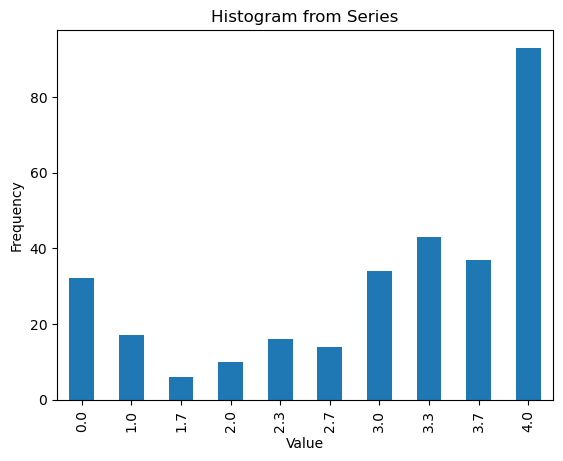

In [57]:
import matplotlib.pyplot as plt

data = out["gpa"].value_counts().sort_index()
data.plot.bar()
plt.title("Histogram from Series")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [58]:
out.to_csv("output.csv")